In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy.linalg as LA

sklearn.decomposition.PCA is documented at https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [2]:
from sklearn.decomposition import PCA

Generate an elliptically shaped random cloud in the plane

## Car Data

In [3]:
data=pd.read_fwf("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
                 header=None,na_values="?")
data.columns=("mpg","cyl","displ","hp","weight","accel","model","origin","carname")
data = data.dropna(axis=0)
print(data[:5])

    mpg  cyl  displ     hp  weight  accel  model  origin  \
0  18.0    8  307.0  130.0  3504.0   12.0     70       1   
1  15.0    8  350.0  165.0  3693.0   11.5     70       1   
2  18.0    8  318.0  150.0  3436.0   11.0     70       1   
3  16.0    8  304.0  150.0  3433.0   12.0     70       1   
4  17.0    8  302.0  140.0  3449.0   10.5     70       1   

                       carname  
0  "chevrolet chevelle malibu"  
1          "buick skylark 320"  
2         "plymouth satellite"  
3              "amc rebel sst"  
4                "ford torino"  


In [4]:
cars=np.array(data[["cyl","mpg","displ","hp","weight","accel"]])
cars=np.array([line for line in cars if line[0] in [4,6,8]])
Y=cars[:,0]/2-2
X=cars[:,1:]
#Y=np.array(data["mpg"])


In [5]:
X[:3], Y[:3]

(array([[  18. ,  307. ,  130. , 3504. ,   12. ],
        [  15. ,  350. ,  165. , 3693. ,   11.5],
        [  18. ,  318. ,  150. , 3436. ,   11. ]]), array([2., 2., 2.]))

In [6]:
np.round(np.corrcoef(X,rowvar=False),3)

array([[ 1.   , -0.818, -0.78 , -0.843,  0.419],
       [-0.818,  1.   ,  0.903,  0.935, -0.561],
       [-0.78 ,  0.903,  1.   ,  0.869, -0.692],
       [-0.843,  0.935,  0.869,  1.   , -0.431],
       [ 0.419, -0.561, -0.692, -0.431,  1.   ]])

## Find Principal components

In [7]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X)
comps=pca.components_
explain=pca.explained_variance_ratio_
for comp, frac in zip(comps,explain):
    print(round(100*frac,5),"percent:", comp)

99.76511 percent: [-0.0076786   0.11404841  0.03920751  0.99267056 -0.00138875]
0.19845 percent: [-0.01797915  0.94308579  0.30724002 -0.1206763  -0.03614883]


## Transform to Princpal Component Frame and Scale

In [8]:
P=pca.transform(X)

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
Q=scaler.fit_transform(P)

XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(Q,Y,test_size=.25)
#XTRAINT=scaler.fit_transform(XTRAIN)
#XTESTT=scaler.transform(XTEST)

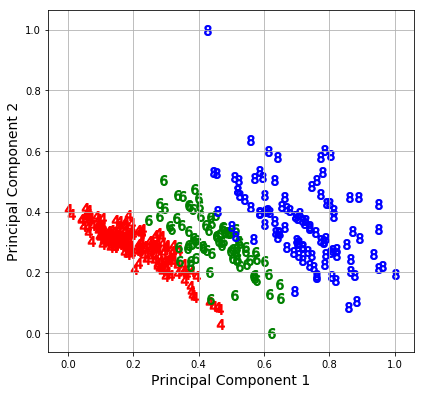

In [11]:
colors=["red", "green","blue"]
markers=["$4$","$6$","$8$"]
nclasses=3
for i in range(nclasses):
    x,y=zip(*Q[Y==i])
    plt.scatter(x,y,marker=markers[i],color=colors[i],s=100)

plt.xlabel("Principal Component 1",fontsize=14)
plt.ylabel("Principal Component 2",fontsize=14)
#plt.ylim([7.5,25])
plt.grid()
fig=plt.gcf()
fig.tight_layout()
fig.set_size_inches(6,6)

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [13]:
svml=SVC(kernel="linear", gamma=10)
XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(Q,Y,test_size=.25)
svml.fit(XTRAIN,YTRAIN)
YP_LSVM=svml.predict(XTEST)
print("accuracy (Linear SVM) = ",accuracy_score(YTEST,YP_LSVM))

svmp=SVC(kernel="poly", degree=3, gamma=10, coef0=3)
svmp.fit(XTRAIN,YTRAIN)
YP_PSVM=svmp.predict(XTEST)
print("accuracy (Polynomial SVM) = ",accuracy_score(YTEST,YP_PSVM))


svm_RBF=SVC(kernel="rbf", gamma=20)
svm_RBF.fit(XTRAIN,YTRAIN)
YP_RBF_SVM=svm_RBF.predict(XTEST)
print("accuracy (RBF SVM) = ",accuracy_score(YTEST,YP_RBF_SVM))

svm_Sigmoid=SVC(kernel="sigmoid", gamma=1, coef0=0)
svm_Sigmoid.fit(XTRAIN,YTRAIN)
YP_Sigmoid_SVM=svm_Sigmoid.predict(XTEST)
print("accuracy (Sigmoid SVM) = ",accuracy_score(YTEST,YP_Sigmoid_SVM))



accuracy (Linear SVM) =  0.9484536082474226
accuracy (Polynomial SVM) =  0.9587628865979382
accuracy (RBF SVM) =  0.9587628865979382
accuracy (Sigmoid SVM) =  0.9278350515463918


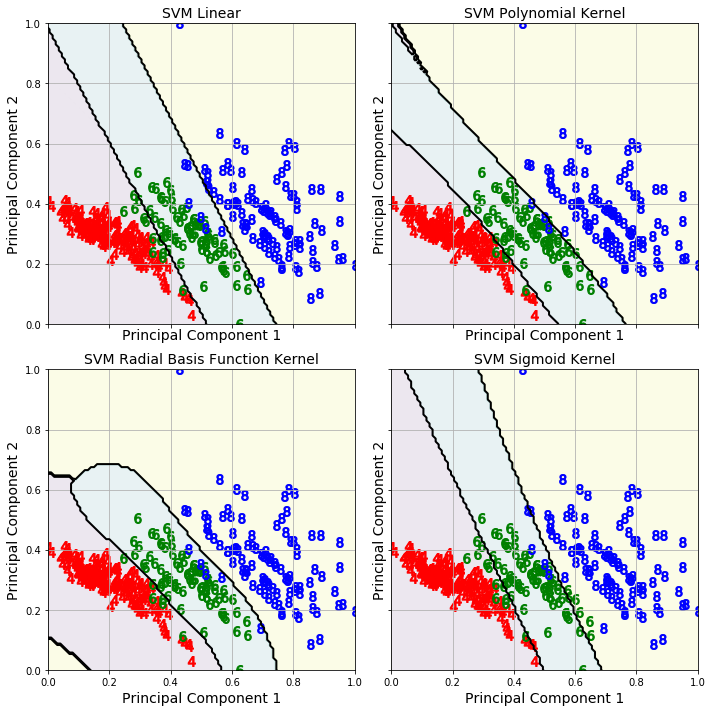

In [14]:
def visualize_PC(ax,clf,X,Y,DX,DY,thelevels,colors,markers,xlab="X",
                                ylab="Y", axtitle="Classification Boundary"):
    xinterval = X[:, 0].min() - 1, X[:, 0].max() + 1
    yinterval = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(*xinterval, DX),
                     np.arange(*yinterval, DY))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    c=ax.contour(xx, yy, Z, alpha=1,levels=thelevels,linewidths=2,colors="k")
    c=ax.contourf(xx, yy, Z, alpha=.1)
        
    nclasses=len(colors)
    for i in range(nclasses):
        x,y=zip(*X[Y==i])
        ax.scatter(x,y,marker=markers[i],color=colors[i],s=100)


    ax.set_xlabel(xlab,fontsize=14)
    ax.set_ylabel(ylab,fontsize=14)
    ax.set_title(axtitle,fontsize=14)
    ax.set_xlim(xinterval)
    ax.set_ylim(yinterval)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.grid()
    return(ax)
    
colors=["red", "green","blue"]
markers=["$4$","$6$","$8$"]

fig,ax=plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True)

visualize_PC(ax[0,0],svml, Q,Y, .01, .01,[0.5,1.5],colors,markers,xlab="Principal Component 1",
            ylab="Principal Component 2",axtitle="SVM Linear")
visualize_PC(ax[0,1],svmp, Q,Y, .01, .01,[0.5,1.5],colors,markers,xlab="Principal Component 1",
            ylab="Principal Component 2",axtitle="SVM Polynomial Kernel")
visualize_PC(ax[1,0],svm_RBF, Q,Y,.01, .01,[0.5,1.5],colors,markers,xlab="Principal Component 1",
            ylab="Principal Component 2",axtitle="SVM Radial Basis Function Kernel")
visualize_PC(ax[1,1],svm_Sigmoid, Q,Y,.01, .01,[0.5,1.5],colors,markers,xlab="Principal Component 1",
            ylab="Principal Component 2",axtitle="SVM Sigmoid Kernel")

fig.set_size_inches(10,10)
fig.tight_layout()
#fig.savefig("SVM-comparison-decision-boundary.pdf")

#visualize_clasifier_contours(gnb,X,Y,.1,.1, [0.5,1.5],colors,markers,"MPG","Acceleratio